In [3]:
import time
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer

from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange

%config InlineBackend.figure_format = 'svg'

In [4]:
device=torch.device("cpu")


In [5]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.to(device)

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

In [6]:

def log_gaussian_loss(output, target, sigma, no_dim):
    exponent = -0.5*(target - output)**2/sigma**2  
    log_coeff = -no_dim*torch.log(sigma) 

    return - (log_coeff + exponent).sum()


def get_kl_divergence(weights, prior, varpost):
    prior_loglik = prior.loglik(weights)
    
    varpost_loglik = varpost.loglik(weights)
    varpost_lik = varpost_loglik.exp()
    
    return (varpost_lik*(varpost_loglik - prior_loglik)).sum()


class gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def loglik(self, weights):
        exponent = -0.5*(weights - self.mu)**2/self.sigma**2
        log_coeff = -0.5*(np.log(2*np.pi) + 2*np.log(self.sigma))
        
        return (exponent + log_coeff).sum()

In [209]:
class BayesLinear_Normalq(nn.Module):
    def __init__(self, input_dim, output_dim, prior):
        super(BayesLinear_Normalq, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.prior = prior
        
        scale = (1/self.input_dim)**0.5
        rho_init = np.log(np.exp((2/self.input_dim)**0.5) - 1)
        self.weight_mus = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-0.05, 0.05))
        self.weight_rhos = nn.Parameter(torch.Tensor(self.input_dim, self.output_dim).uniform_(-2, -1))
        
        self.bias_mus = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-0.05, 0.05))
        self.bias_rhos = nn.Parameter(torch.Tensor(self.output_dim).uniform_(-2, -1))
        
    def forward(self, x, sample = True):

        
        if sample:
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            bias_epsilons =  Variable(self.bias_mus.data.new(self.bias_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            bias_stds = torch.log(1 + torch.exp(self.bias_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            bias_sample = self.bias_mus + bias_epsilons*bias_stds
            
            output = torch.mm(x, weight_sample) + bias_sample
            
            # computing the KL loss term
            prior_cov, varpost_cov = self.prior.sigma**2, weight_stds**2
            KL_loss = 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*weight_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.weight_mus - self.prior.mu)**2/prior_cov).sum()
            
            prior_cov, varpost_cov = self.prior.sigma**2, bias_stds**2
            KL_loss = KL_loss + 0.5*(torch.log(prior_cov/varpost_cov)).sum() - 0.5*bias_stds.numel()
            KL_loss = KL_loss + 0.5*(varpost_cov/prior_cov).sum()
            KL_loss = KL_loss + 0.5*((self.bias_mus - self.prior.mu)**2/prior_cov).sum()
            
            return output, KL_loss
        
        else:
            output = torch.mm(x, self.weight_mus) + self.bias_mus
            return output, KL_loss
        
    def sample_layer(self, no_samples):
        all_samples = []
        for i in range(no_samples):
            # sample gaussian noise for each weight and each bias
            weight_epsilons = Variable(self.weight_mus.data.new(self.weight_mus.size()).normal_())
            
            # calculate the weight and bias stds from the rho parameters
            weight_stds = torch.log(1 + torch.exp(self.weight_rhos))
            
            # calculate samples from the posterior from the sampled noise and mus/stds
            weight_sample = self.weight_mus + weight_epsilons*weight_stds
            
            all_samples += weight_sample.view(-1).cpu().data.numpy().tolist()
            
        return all_samples

In [103]:
class BBP_Homoscedastic_Model(nn.Module):
    def __init__(self, input_dim, output_dim, no_units, init_log_noise):
        super(BBP_Homoscedastic_Model, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # network with two hidden and one output layer

        self.layer1 = BayesLinear_Normalq(input_dim, no_units, gaussian(0, 1))
        self.layer2 = BayesLinear_Normalq(no_units, output_dim, gaussian(0,1))
        
        # activation to be used between hidden layers
        self.activation = nn.ReLU(inplace = True)
#         self.log_noise = nn.Parameter(torch.cuda.FloatTensor([init_log_noise]))
        self.log_noise = nn.Parameter(torch.FloatTensor([init_log_noise]))

    
    def forward(self, x):
        

        KL_loss_total = 0
        x = x.view(-1, self.input_dim)
        
        x, KL_loss = self.layer1(x)

        KL_loss_total = KL_loss_total + KL_loss
        x = self.activation(x)
        
        x, KL_loss = self.layer2(x)
        KL_loss_total = KL_loss_total + KL_loss
        
        return x, KL_loss_total

In [174]:
from IPython.core.debugger import set_trace
class BBP_Homoscedastic_Model_Wrapper:
    def __init__(self, input_dim, output_dim, no_units, learn_rate, batch_size, no_batches, init_log_noise,params):
        


        self.learn_rate = learn_rate
        self.batch_size = batch_size
        self.no_batches = no_batches
        
        self.network = BBP_Homoscedastic_Model(input_dim = input_dim, output_dim = output_dim,
                                               no_units = no_units, init_log_noise = init_log_noise)
        self.network.to(device)

        self.optimizer = torch.optim.Adam(self.network.parameters(), lr =self.learn_rate)
        self.loss_func = log_gaussian_loss
        self.params=params
    def fit(self, x, y, no_samples):
        x, y = to_variable(var=(x, y), cuda=False)
        # reset gradient and total loss
        self.optimizer.zero_grad()
        fit_loss_total = 0
        c_loss=torch.zeros(no_samples, 1)
        x_point=torch.linspace(0.,1.2,50)[:,None].to(device)

        
        for i in range(no_samples):
            output, KL_loss_total = self.network(x)
            sample_output,_=self.network(x_point)
            sample_output_0=sample_output[:-1]
            sample_output_1=sample_output[1:]
            diff_vector=sample_output_0-sample_output_1
            diff_vector[diff_vector<0]=0
            diff1=sample_output-fun_UB(x_point.cpu()).to(device)  #ub
            diff2=torch.FloatTensor(constant_function(0)(x_point.cpu())).to(device)-sample_output#lb
            diff1[diff1<0]=0
            diff2[diff2<0]=0
            # calculate fit loss based on mean and standard deviation of output
            fit_loss_total = fit_loss_total + self.loss_func(output, y, self.network.log_noise.exp(), self.network.output_dim)
            c_loss[i]=self.params[0]*torch.mean(diff1)+self.params[1]*torch.mean(diff2) +self.params[2]*torch.mean(diff_vector)

        cons_loss_1=c_loss.mean()
        KL_loss_total = KL_loss_total/self.no_batches
        total_loss = (fit_loss_total + KL_loss_total)/(no_samples*x.shape[0])+cons_loss_1.to(device)
        total_loss.backward()
        self.optimizer.step()

        return fit_loss_total/no_samples, KL_loss_total,cons_loss_1

In [175]:
torch.random.seed()
no_points = 300
lengthscale = 1
variance = 1.0
sig_noise = 0.1
def fun(x):
    return (np.arctan(20*x - 10) - np.arctan(-10))/3        
def constant_function(val):
    """ Return the constant function"""
    def fun(x):
        return torch.zeros(x.shape[0])+val
    
    return fun

def fun_UB(x):
    """ Upper bound function """
    return torch.log(25*x.flatten() + 1)/3+0.05      



x_test = np.linspace(0, 1, 100)
y_true = fun(x_test)

n = 100
noise_std = 0.1
np.random.seed(1)
x_design = np.random.uniform(0.1, 0.65, n)
x_design.sort(axis = 0)
np.random.seed(10)
y_design = fun(x_design) + np.random.normal(0, noise_std, n)

positive_index=np.where(y_design>=0)[0]
x_design=x_design[positive_index]
y_design=y_design[positive_index]
# diff_y=np.diff(y_design)
# print(diff_y)
# mono_index=(np.where(diff_y<1e-8))[0]+1
train=np.stack((x_design,y_design),axis=-1)
np.random.shuffle(train)

x_mean, x_std = x_design.mean(), x_design.var()**0.5
y_mean, y_std = y_design.mean(), y_design.var()**0.5
x_train=  torch.FloatTensor(x_design[:,np.newaxis])      
y_train=  torch.FloatTensor(y_design[:,np.newaxis])      
x_test=  torch.FloatTensor(x_test)      
y_true=  torch.FloatTensor(y_true)   
print(x_mean, x_std,y_mean, y_std)


sigma=0.1

ntrain=n

0.39002997648690874 0.15905669404006317 0.330080644951817 0.31368231521073986


In [176]:
x_train.shape

torch.Size([87, 1])

In [203]:

num_epochs, batch_size, nb_train = 6000, len(x_train), len(x_train)
net = BBP_Homoscedastic_Model_Wrapper(input_dim = 1, output_dim = 1, no_units = 100, learn_rate =5e-3,
                                      batch_size = batch_size, no_batches = 1, init_log_noise = 0,params=(2,1,1))

constraint_loss=np.zeros(num_epochs)
fit_loss_train = np.zeros(num_epochs)
KL_loss_train = np.zeros(num_epochs)
total_loss = np.zeros(num_epochs)

best_net, best_loss = None, float('inf')

for i in range(num_epochs):
    
    fit_loss, KL_loss,constraint = net.fit(x_train, y_train, no_samples = 5)
    fit_loss_train[i] += fit_loss.cpu().data.numpy()
    KL_loss_train[i] += KL_loss.cpu().data.numpy()
    constraint_loss[i]+=constraint.cpu().data.numpy()
    total_loss[i] = fit_loss_train[i] + KL_loss_train[i]+constraint_loss[i]
    loss_compare= fit_loss
    if loss_compare< best_loss:
        best_loss = loss_compare
        best_net = copy.deepcopy(net.network)
        
    if i % 100 == 0 or i == num_epochs - 1:
        
        print("Epoch: %5d/%5d, Fit loss = %8.3f, KL loss = %8.3f, Constraint Loss =%8.3f, noise = %6.3f" %
              (i + 1, num_epochs, fit_loss_train[i], KL_loss_train[i],constraint_loss[i], net.network.log_noise.exp().cpu().data.numpy()))

        samples = []
#         for i in range(100):
#             preds = net.network.forward(torch.linspace(0.1, 0.6, 200).cuda())[0]
#             samples.append(preds.cpu().data.numpy()[:, 0])

Epoch:     1/ 6000, Fit loss =   22.836, KL loss =  335.541, Constraint Loss =   0.218, noise =  0.995


Epoch:   101/ 6000, Fit loss =  -14.301, KL loss =  324.226, Constraint Loss =   0.022, noise =  0.617


Epoch:   201/ 6000, Fit loss =  -49.622, KL loss =  314.302, Constraint Loss =   0.064, noise =  0.429


Epoch:   301/ 6000, Fit loss =  -53.273, KL loss =  304.730, Constraint Loss =   0.019, noise =  0.347


Epoch:   401/ 6000, Fit loss =  -70.611, KL loss =  296.934, Constraint Loss =   0.032, noise =  0.309


Epoch:   501/ 6000, Fit loss =  -82.942, KL loss =  289.065, Constraint Loss =   0.042, noise =  0.276


Epoch:   601/ 6000, Fit loss =  -80.140, KL loss =  285.892, Constraint Loss =   0.047, noise =  0.251


Epoch:   701/ 6000, Fit loss =  -88.791, KL loss =  279.259, Constraint Loss =   0.086, noise =  0.223


Epoch:   801/ 6000, Fit loss = -100.237, KL loss =  274.448, Constraint Loss =   0.127, noise =  0.206


Epoch:   901/ 6000, Fit loss =  -74.033, KL loss =  269.721, Constraint Loss =   0.211, noise =  0.194


Epoch:  1001/ 6000, Fit loss = -109.451, KL loss =  262.634, Constraint Loss =   0.182, noise =  0.184


Epoch:  1101/ 6000, Fit loss = -108.865, KL loss =  259.654, Constraint Loss =   0.235, noise =  0.180


Epoch:  1201/ 6000, Fit loss = -111.606, KL loss =  254.101, Constraint Loss =   0.265, noise =  0.173


Epoch:  1301/ 6000, Fit loss = -111.037, KL loss =  249.109, Constraint Loss =   0.178, noise =  0.176


Epoch:  1401/ 6000, Fit loss = -116.890, KL loss =  248.153, Constraint Loss =   0.135, noise =  0.160


Epoch:  1501/ 6000, Fit loss = -136.630, KL loss =  248.339, Constraint Loss =   0.144, noise =  0.135


Epoch:  1601/ 6000, Fit loss = -134.066, KL loss =  248.056, Constraint Loss =   0.136, noise =  0.113


Epoch:  1701/ 6000, Fit loss = -158.750, KL loss =  253.106, Constraint Loss =   0.068, noise =  0.109


Epoch:  1801/ 6000, Fit loss = -156.630, KL loss =  253.218, Constraint Loss =   0.077, noise =  0.101


Epoch:  1901/ 6000, Fit loss = -157.162, KL loss =  252.092, Constraint Loss =   0.068, noise =  0.098


Epoch:  2001/ 6000, Fit loss = -159.288, KL loss =  251.968, Constraint Loss =   0.056, noise =  0.102


Epoch:  2101/ 6000, Fit loss = -160.993, KL loss =  251.515, Constraint Loss =   0.075, noise =  0.102


Epoch:  2201/ 6000, Fit loss = -161.359, KL loss =  249.892, Constraint Loss =   0.057, noise =  0.097


Epoch:  2301/ 6000, Fit loss = -162.348, KL loss =  246.346, Constraint Loss =   0.074, noise =  0.096


Epoch:  2401/ 6000, Fit loss = -127.429, KL loss =  243.664, Constraint Loss =   0.062, noise =  0.097


Epoch:  2501/ 6000, Fit loss = -162.156, KL loss =  245.243, Constraint Loss =   0.064, noise =  0.099


Epoch:  2601/ 6000, Fit loss = -161.324, KL loss =  242.251, Constraint Loss =   0.064, noise =  0.097


Epoch:  2701/ 6000, Fit loss = -163.049, KL loss =  241.590, Constraint Loss =   0.065, noise =  0.096


Epoch:  2801/ 6000, Fit loss = -162.644, KL loss =  237.447, Constraint Loss =   0.069, noise =  0.095


Epoch:  2901/ 6000, Fit loss = -162.929, KL loss =  235.003, Constraint Loss =   0.063, noise =  0.095


Epoch:  3001/ 6000, Fit loss = -163.343, KL loss =  233.494, Constraint Loss =   0.062, noise =  0.096


Epoch:  3101/ 6000, Fit loss = -163.092, KL loss =  232.138, Constraint Loss =   0.065, noise =  0.097


Epoch:  3201/ 6000, Fit loss = -162.236, KL loss =  232.724, Constraint Loss =   0.062, noise =  0.099


Epoch:  3301/ 6000, Fit loss = -162.303, KL loss =  231.655, Constraint Loss =   0.149, noise =  0.095


Epoch:  3401/ 6000, Fit loss = -157.457, KL loss =  232.553, Constraint Loss =   0.060, noise =  0.103


Epoch:  3501/ 6000, Fit loss = -162.914, KL loss =  233.114, Constraint Loss =   0.056, noise =  0.101


Epoch:  3601/ 6000, Fit loss = -162.996, KL loss =  232.843, Constraint Loss =   0.066, noise =  0.097


Epoch:  3701/ 6000, Fit loss = -162.533, KL loss =  231.956, Constraint Loss =   0.072, noise =  0.100


Epoch:  3801/ 6000, Fit loss = -163.113, KL loss =  231.766, Constraint Loss =   0.062, noise =  0.098


Epoch:  3901/ 6000, Fit loss = -163.569, KL loss =  231.547, Constraint Loss =   0.063, noise =  0.095


Epoch:  4001/ 6000, Fit loss = -126.425, KL loss =  229.487, Constraint Loss =   0.061, noise =  0.094


Epoch:  4101/ 6000, Fit loss = -162.979, KL loss =  229.570, Constraint Loss =   0.062, noise =  0.095


Epoch:  4201/ 6000, Fit loss = -159.726, KL loss =  227.195, Constraint Loss =   0.058, noise =  0.094


Epoch:  4301/ 6000, Fit loss = -163.197, KL loss =  225.111, Constraint Loss =   0.058, noise =  0.094


Epoch:  4401/ 6000, Fit loss =  -94.675, KL loss =  224.356, Constraint Loss =   0.057, noise =  0.098


Epoch:  4501/ 6000, Fit loss = -163.257, KL loss =  224.722, Constraint Loss =   0.070, noise =  0.095


Epoch:  4601/ 6000, Fit loss = -161.360, KL loss =  224.112, Constraint Loss =   0.059, noise =  0.095


Epoch:  4701/ 6000, Fit loss = -163.600, KL loss =  223.900, Constraint Loss =   0.074, noise =  0.094


Epoch:  4801/ 6000, Fit loss = -162.859, KL loss =  222.571, Constraint Loss =   0.064, noise =  0.096


Epoch:  4901/ 6000, Fit loss = -162.393, KL loss =  224.383, Constraint Loss =   0.061, noise =  0.100


Epoch:  5001/ 6000, Fit loss = -162.765, KL loss =  222.859, Constraint Loss =   0.115, noise =  0.095


Epoch:  5101/ 6000, Fit loss = -162.782, KL loss =  222.257, Constraint Loss =   0.059, noise =  0.100


Epoch:  5201/ 6000, Fit loss = -163.206, KL loss =  222.096, Constraint Loss =   0.085, noise =  0.098


Epoch:  5301/ 6000, Fit loss = -163.423, KL loss =  221.449, Constraint Loss =   0.060, noise =  0.095


Epoch:  5401/ 6000, Fit loss = -163.110, KL loss =  219.790, Constraint Loss =   0.059, noise =  0.095


Epoch:  5501/ 6000, Fit loss = -163.345, KL loss =  218.275, Constraint Loss =   0.064, noise =  0.094


Epoch:  5601/ 6000, Fit loss = -163.392, KL loss =  218.830, Constraint Loss =   0.064, noise =  0.095


Epoch:  5701/ 6000, Fit loss = -162.422, KL loss =  219.464, Constraint Loss =   0.069, noise =  0.100


Epoch:  5801/ 6000, Fit loss = -162.182, KL loss =  218.212, Constraint Loss =   0.059, noise =  0.095


Epoch:  5901/ 6000, Fit loss = -156.411, KL loss =  218.932, Constraint Loss =   0.058, noise =  0.098


Epoch:  6000/ 6000, Fit loss = -162.063, KL loss =  219.406, Constraint Loss =   0.063, noise =  0.095


In [238]:
net.network.load_state_dict(torch.load('./BBB_saved/soft_constraint_1_1_1.pth'))

<All keys matched successfully>

In [230]:
# torch.save(net.network.state_dict(), './soft_constraint_1_2_1.pth')

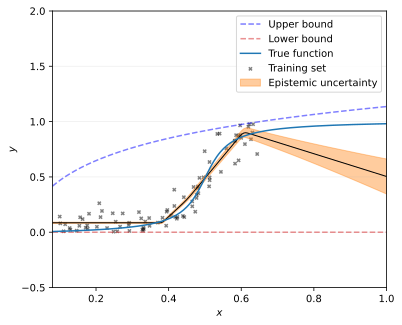

In [239]:
y_up=fun_UB(torch.linspace(0.08, 1, 200))
x_test=torch.linspace(0.08, 1, 200)
samples = []
for i in range(50):
#     preds = (best_net.forward(torch.linspace(0, 1, 200).cuda())[0] ) 
    preds = (net.network.forward(torch.linspace(0, 1, 200))[0] ) 

    samples.append(preds.cpu().data.numpy()[:, 0])

samples = np.array(samples)
means = samples.mean(axis = 0)

aleatoric = best_net.log_noise.exp().cpu().data.numpy()
epistemic = samples.var(axis = 0)**0.5
total_unc = (aleatoric**2 + epistemic**2)**0.5


samples = []
for i in range(500):
    preds = (net.network.forward(torch.linspace(0.08, 1, 200).to(device))[0] ) 
    samples.append(preds.cpu().data.numpy()[:, 0])

samples = np.array(samples)
means = samples.mean(axis = 0)

aleatoric = net.network.log_noise.exp().cpu().data.numpy()
epistemic = samples.var(axis = 0)**0.5
total_unc = (aleatoric**2 + epistemic**2)**0.5


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize = (6, 5))
plt.style.use('default')
plt.scatter(x_train , y_train , s = 10, marker = 'x', color = 'black', alpha = 0.5,label='Training set')
plt.fill_between(np.linspace(0.08, 1, 200), means - epistemic, means + epistemic, color = c[1], alpha = 0.4, label = 'Epistemic uncertainty')
plt.plot(np.linspace(0.08, 1, 200), means, color = 'black', linewidth = 1)
plt.plot(x_test.numpy(),y_up.numpy(),color='blue', linestyle='--',alpha=0.5,label='Upper bound')
plt.axhline(y=0., color=c[3], linestyle='--',alpha=0.5,label='Lower bound')
plt.plot(x_test.numpy(),fun(x_test.numpy()),label='True function')


plt.xlim([0.08, 1])
plt.ylim([-0.5,2])
plt.xlabel('$x$', fontsize=10)
plt.ylabel('$y$', fontsize=10)

# plt.title('With Soft Constraints', fontsize=10)
plt.tick_params(labelsize=10)
plt.gca().yaxis.grid(alpha=0.2)
plt.legend()
plt.savefig('./aleatoric/results/soft_constraint_1_1_1_new.jpg')
plt.show()









In [240]:
def violate(result):
    #first constraint:
    diff1=result-fun_UB(torch.linspace(0.08, 1, 200).cpu()).numpy()  #ub
    diff2=torch.FloatTensor(constant_function(0)(torch.linspace(0.08, 1, 200).cpu())).numpy()-result#lb
    diff1[diff1<0.0001]=0
    diff2[diff2<0.0001]=0
    sample_output_0=result[:-1]
    sample_output_1=result[1:]
    diff_vector=sample_output_0-sample_output_1
    diff_vector[diff_vector<0.0001]=0
    v1=diff1.mean
    print(diff1.shape)
    v1,v2,v3=diff1.mean(),diff2.mean(),diff_vector.mean()
    c1,c2,c3=np.count_nonzero(diff1>0.0001), np.count_nonzero(diff2>0.0001),np.count_nonzero(diff_vector>0.0001)
    return v1, v2, v3,c1,c2,c3




In [241]:
print(violate(means))
x_test = np.linspace(0.08, 1, 200)
y_true = fun(x_test)
MSE=F.mse_loss(torch.tensor(means),torch.tensor(y_true))
print('MSE:',MSE)
pred_std=np.mean(np.var(samples,axis=0)**0.5)
print('STD: ',pred_std)

(200,)
(0.0, 0.0, 0.0019861187, 0, 0, 84)
MSE: tensor(0.0361, dtype=torch.float64)
STD:  0.04708835
